In [37]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import morton
import glob
from scipy.fft import fft,fftfreq
import numpy as np
import seaborn as sb
import math

In [38]:
test_data= "./Data/route_2_inner_10.0km-h_50Hz_data.csv"
test2="./Data/route_2_inner_15.0km-h_50Hz_data.csv"
simuPath ='./Data/'

In [80]:
def load_corrodinates_and_Plot_trace(fileName,key1,key2):
    df = pd.read_csv(fileName, sep=',', usecols = [key1,key2])
    plt.scatter(x=df[key1],y=df[key2])


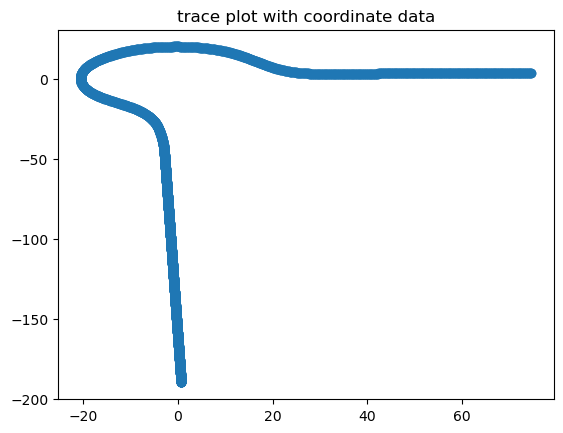

In [40]:
load_corrodinates_and_Plot_trace(test_data,"location_x","location_y")

In [41]:
df = pd.read_csv(test2, sep=',')
df["groundSpeed"].describe()

count    2939.000000
mean       14.533211
std         1.177792
min         0.340403
25%        14.657918
50%        14.658597
75%        14.659072
max        16.885302
Name: groundSpeed, dtype: float64

In [42]:
df["northHeading"].describe()

count    1410.000000
mean        2.764725
std         0.841459
min         0.731067
25%         2.362771
50%         3.166263
75%         3.166277
max         3.963343
Name: northHeading, dtype: float64

In [81]:
def load_Speed_and_Heading_From_MetaDATA_then_calculate_and_plot(fileName,ts_key,heading_key,speed_key):
    df=pd.read_csv(fileName, sep=',', usecols = [ts_key,heading_key,speed_key])
    df = df.sort_values(by=[ts_key])
    start=False
    lastHeading=0
    deltaHeading=0
    currentHeading=365
    currentX=0
    currentY=0
    lastSpeedTS=0
    lastSpeed=0
    currentSpeed=0
    currentSpeedTS=0
    trace_df= pd.DataFrame(columns= [ts_key,'x_position','y_position'])
    for row in df.itertuples():
        if not pd.isna(row.northHeading):
            if not start:
                start = True
                lastSpeedTS=row.Timestamp
                lastHeading= row.northHeading
            lastHeading=currentHeading
            currentHeading=row.northHeading
            deltaHeading=currentHeading-lastHeading
            # if deltaHeading<-300:
            #     currentHeading=-currentHeading-360
            # if deltaHeading>300:
            #     currentHeading=currentHeading-360
        if not pd.isna(row.groundSpeed):
            if start:
                currentSpeed=row.groundSpeed
                currentSpeedTS=row.Timestamp
                delta_t=currentSpeedTS-lastSpeedTS
                delta_range=delta_t*(currentSpeed+lastSpeed)/7
                currentX=currentX+delta_range*math.cos(currentHeading)
                currentY= currentY+delta_range*math.sin(currentHeading)
                new_row = pd.Series({ts_key: currentSpeedTS, 'y_position':-currentX-200,'x_position':currentY})
                trace_df=pd.concat([trace_df, new_row.to_frame().T], ignore_index=True)
                lastSpeed=currentSpeed
                lastSpeedTS=currentSpeedTS
    # plt.figure(figsize=(5,30))
    plt.scatter(x=trace_df['x_position'],y=trace_df['y_position'])
    
    return trace_df



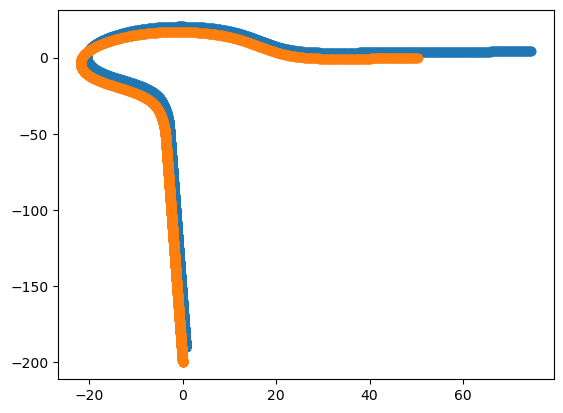

In [82]:
load_corrodinates_and_Plot_trace(test_data,"location_x","location_y")
load_Speed_and_Heading_From_MetaDATA_then_calculate_and_plot(test_data,'Timestamp','northHeading','groundSpeed')



In [59]:
ref_df=df[["location_x","location_y"]].dropna()
new_df=df_ns[['x_position','y_position']].dropna()
new_df.corrwith(ref_df,axis=1)

      location_x  location_y
1       0.700499 -189.727951
3       0.700499 -189.727951
5       0.700499 -189.727951
7       0.700499 -189.727951
9       0.700499 -189.727951
...          ...         ...
2934   73.729744    4.121829
2935   73.933311    4.124817
2936   74.136871    4.127813
2937   74.340439    4.130786
2938   74.543999    4.133780

[1528 rows x 2 columns]


1      NaN
3      NaN
5      NaN
7      NaN
9      NaN
        ..
2934   NaN
2935   NaN
2936   NaN
2937   NaN
2938   NaN
Length: 2581, dtype: float64

In [ ]:
ref_csv_files = glob.glob(os.path.join(RoundaboutProvidedPath, "*.csv"))
extract_csv_files = glob.glob(os.path.join(RoundaboutExtractPath, "*.csv"))
fig,ax = plt.subplots(3,3,figsize=(15, 15),sharex='all')
custom_xlim=(-30,30)
plt.setp(ax, xlim=custom_xlim)
n_col=0
n_row=0
for ref_file in ref_csv_files:
    for ext_file in extract_csv_files:
        if ref_file[-5]== ext_file[-5]:
            ref_df = pd.read_csv(ref_file,sep=',')
            ext_df = pd.read_csv(ext_file,sep=',')
            if len(ref_df)>0:
                l1=ax[n_row,n_col].axvline(x=0,color="c")
                l2=ax[n_row,n_col].axvline(x=6,color="y")
                l3=ax[n_row,n_col].scatter(x=ref_df['RadiusOfTurn'],y=ref_df['sample_ts'],c='r',s=1,marker="o")
                l4=ax[n_row,n_col].scatter(x=ext_df['RadiusOfTurn'],y=ext_df['sample_ts'],c='b',s=0.5,marker="x")
                secax=ax[n_row,n_col].twiny()
                secax.set_xlim(-0.5,0.5)
                secax.set_xlabel('Yaw Rate')
                l5=secax.scatter(x=ref_df['IMUYawRate'],y=ref_df['sample_ts'],c='g',s=1,marker="o")
                l6=secax.scatter(x=ext_df['IMUYawRate'],y=ext_df['sample_ts'],c='orange',s=0.5,marker="x")
                ax[n_row,n_col].set_title(ref_file[-5:])
                n_col=n_col+1
                if n_col==3:
                    n_col=0
                    n_row=n_row+1
fig.delaxes(ax[2][2])
fig.delaxes(ax[2][1])
fig.supxlabel('Turn Radius')
fig.supylabel('Time stamp')

fig.legend((l1,l2,l3,l4,l5,l6),("x=0","x=6","Turn Radius of Entire Maneuver", "Turn Radius of AOI","Yaw Rate of Entire maneuver","Yaw Rate of AOI"), loc='lower right',bbox_to_anchor=(0.9, 0.25))



In [52]:
df_ns.describe()

,Timestamp,x_position,y_position
count,2105.000000,2105.000000,2105.000000
mean,377.027453,0.302039,231.166083
std,30.390274,25.259400,121.423262
min,324.427452,-38.253793,-0.000000
25%,350.727452,-7.310261,124.573003
50%,377.027453,-3.724281,252.993993
75%,403.327453,-0.627957,349.086541
max,429.627453,87.930317,379.603212
